# Implicit ODE with Newton-Raphson
The Newton-Raphson method can be used as well for an alternative
approach to integrating ODEs, such as the one that appeared in the sky diver
problem. So far we have used an _explicit_ forward integration which
involves evaluating the RHS of the ODE using the know velocity
$ v_n $ at the present time to get the value of the
velocity at the next time step $ n+1 $. In cases where
we are interested in the longer-term behaviour, and where we are
required to take larger time steps this may not work very well. In
that case we want to evaluate the RHS for $ v(n+1) $, and we have
an _implicit_ solution scheme. Especially for large coupled systems of
ODEs implicit schemes often provide the numerical stability to find a
solution at all. The implicit solution involves an iterative approach,
and we can use again the Newton-Raphson method.

As you can see the basic strategy is to put everything on one side,
give it a name $ G(v_{n+1})$, set this function to zero and
solve it by Newton-Raphson. The beauty is that this idea can be easily
expanded to systems of ODEs with many variables. In physics this 
method is for example used for large reaction rate networks involving
thousands of isotopes, solving radiation transfer problems or computing the evolution of stars in spherical symmetry according to the conservation laws of mass, momentum and energy.

Let's implement the skydiver problem as an implicit solution. Recall that the differential equation was just $$ \frac{dv}{dt} = -g +  k v^2$$ and we may add the equation for the height of the skydiver $$ \frac{dh}{dt} = v$$ (see Lecture 2 in Week 4). The explicit solution scheme is $$ v_{n+1} = v_{n} +dt( -g +  k v_{n}^2),$$ whereas the implicit solution would be $$ v_{n+1} = v_{n} +dt( -g +  k v_{n+1}^2).$$

### Explicit:

In [3]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [16]:
k = 0.0022; g = 9.8 
v_t = sqrt(g/k)
h   = 2000   # jump-off height [m]
h_p = 300    # end of free flight, pull parachute height [m]

# make an estimate on what a good step size would be
dh = 10        # typical spatial step at terminal velocity [m]
dt = dh / v_t   # turn that into a dt time step by using v_terminal as characteristic velocity of problem

In [17]:
dt # time step in s
t_max = dt*(h-h_p)/dh
t_max

25.471072026989393

In [18]:
def rhs_sdiver(x,dt):
    'Evaluate RHS for skydiver problem, advance one time step'
    h = x[0] + dt*x[1]
    v = x[1] + dt*(k*x[1]**2 - g)
    return [h,v]

<IPython.core.display.Javascript object>


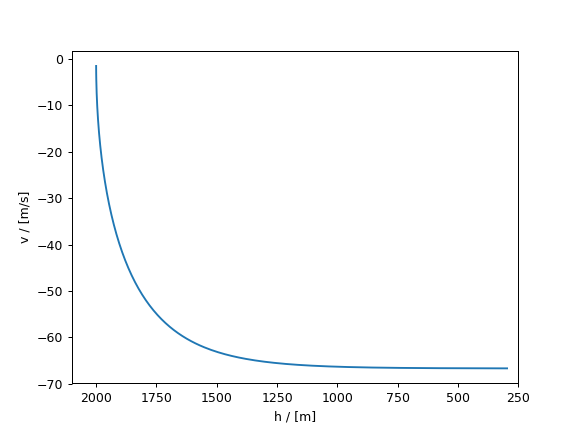

In [19]:
hv_all = []
hv = array([h,0])
while hv[0] > h_p:
    hv = rhs_sdiver(hv,dt)
    hv_all.append(hv)
hv_10 = array(hv_all).T
figure(3)
plot(hv_10[0],hv_10[1])
xlim(2100,250)
xlabel('h / [m]')
ylabel('v / [m/s]')

<IPython.core.display.Javascript object>


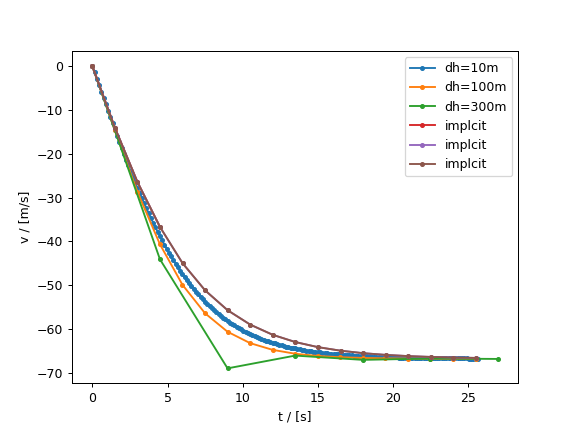

In [21]:
dh = [10,100, 300]
close(2)
figure(2)
for this_dh in dh:
    dt = this_dh / v_t
    tv_all = [[0,0]] # each element is [t, v]
    hv = array([h,0]); t = 0
    while t < t_max:
        hv = rhs_sdiver(hv,dt)
        t += dt
        tv_all.append([t,hv[1]])
    tv = array(tv_all).T
    plot(tv[0],tv[1],'.-',label='dh='+str(this_dh)+'m')
xlabel('t / [s]')
ylabel('v / [m/s]')
legend(loc=1)

Next we consider the **implicit** solution, which involves finding the root of $$ v_{n+1} = v_{n} +dt( -g +  k v_{n+1}^2)$$ where in each time step $v_{n+1}$ is the independent variable. In other words, if $$ G(v_{n+1}) =  - v_{n+1} + v_{n} +dt( -g +  k v_{n+1}^2)$$ then find for each time step $ G(v_{n+1}) = 0$.

In [23]:
# setup NR difference equation for one time step to be iterated over 
# by finding the root at each iteration and updating the 
G = lambda v_np1: -v_np1 + vn + dt*(-g + k*v_np1**2)
v=[]
t=[]
vn = 0 # velocity at t=0
tt = 0
v.append(vn)
t.append(tt)
dt=1.5

<IPython.core.display.Javascript object>


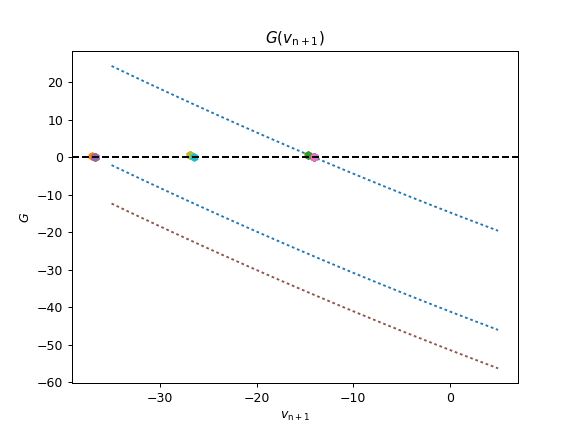

In [28]:
# check how G looks like, what are we trying to find the root of?
#close(4)
figure(4)
x=linspace(-35,5)
plot(x,G(x),':')
axhline(color='k',linestyle='dashed')
title('$G(v_\mathrm{n+1})$')
xlabel('$v_\mathrm{n+1}$')
ylabel('$G$')

In [29]:
xx=0; h=0.01   # we start with an estimate for v_n+1 = 0

In [31]:
# numerical derivative
def derivs(f,x,h):
    '''
    Return 1st order numerical derivative
    
    f : function
    x : x value to evaluate derivative
    h : interval in x for derivative
    '''
    
    dfdx = (f(x+h) - f(x))/h
    return dfdx

In [46]:
# one NR iteration, repeat until satisfactory solution is found
# x is the estimate for v_n+1 and accepted as solution if 
# G(xx) < eps1 and delta < eps2, where eps1 and eps2 are 
# suitably small limits
x = xx
delta = -G(x)/derivs(G,x,h)
xx = x + delta
print(xx,G(xx),delta)
plot(xx,G(xx),'h')

-36.69786178051128 -7.235088972379344e-09 0.00022427494000662254


In [47]:
#figure(4)
plot(xx,G(xx),'h')

In [48]:
# accept solution and advance time
v.append(xx)
tt += dt
t.append(tt)
# new solution becomes old solution
vn = xx
# start new NR iterations

In [49]:
# plot new G
x=linspace(-35,5)
plot(x,G(x),':')
axhline(color='k',linestyle='dashed')
title('$G(v_\mathrm{n+1})$')
xlabel('$v_\mathrm{n+1}$')
ylabel('$G$')

In [53]:
# add implicit soln to fig 2 above
figure(2)
plot(t,v,'.-',label='implcit')
legend(loc=0)

In [54]:
# put it all together in one loop with termination condition for delta
# and finish integration until t = t_max
while tt < t_max:
    delta =0.5
    while delta > 0.001:
        x = xx
        delta = -G(x)/derivs(G,x,h)
        xx = x + delta
        print(xx,G(xx))
    v.append(xx)
    tt += dt
    t.append(tt)
    vn = xx